# Autoencoder learning
_María Camila Vásquez Correa_

In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc

## Multilayer perceptron
The class model receives a list of layers (with its respective activation function) along with the loss that is going to be used for the training to initialize.
* The fit method performs the training on X and y using learning rate lr, a number of epochs epochs, a batch_size and stops given a tolerance tol.
* The evaluate method gives the prediction for an X
* The score method gives the cost function for an X and y

In [0]:
class Model:
    def __init__(self, layers, loss):
        self.layers = layers
        self.loss = loss
    
    def fit(self, X, y, lr, epochs, batch_size, tol,print_loss = True):
        if self.loss.history:
            self.initialize()
        total_loss = np.inf
        j = 0
        test_loss = []
        while j <= epochs and total_loss >= tol:
            _loss = 0
            batches = len(y)//batch_size
            for i in range(batches):
                y_pred = self.forward_pass(X[i*batch_size:(i+1)*batch_size])
                loss_ = self.loss.forward_pass(y_pred,y[i*batch_size:(i+1)*batch_size])
                loss_gradient = loss.backward_pass(y_pred, y[i*batch_size:(i+1)*batch_size])
                self.backward_pass(loss_gradient)
                self.update_parameters(lr)
                _loss += loss_
            total_loss = _loss/batches
            y_pred_test = self.forward_pass(X_test)
            test_loss.append(loss.forward_pass(X_test, y_pred_test))
            loss.history.append(total_loss)
            self.update_gradient_history()
            if print_loss:
                print(f'epoch {j}: loss {total_loss}') 
            j += 1
        return(test_loss)
    
    def initialize(self):
        for layer in self.layers:
            if layer.trainable:
                layer.initialize()
        self.loss.initialize()
    
    def forward_pass(self, X):
        x = X.copy()
        for layer in self.layers:
            a = layer.forward_pass(x)
            x = a
        return x
    
    def backward_pass(self, upstream_gradient):
        for layer in reversed(self.layers):
            upstream_gradient = layer.backward_pass(upstream_gradient)                
        return upstream_gradient
    
    def update_parameters(self,lr):
        for layer in self.layers:
            if layer.trainable:
                layer.update_parameters(lr)
                
    def update_gradient_history(self):
        for layer in self.layers:
            if layer.trainable:
                layer.gradient_history.append([np.sum(layer.gradient_history_w),np.sum(layer.gradient_history_b)])
                layer.gradient_history_w = []
                layer.gradient_history_b = []
    
    def evaluate(self, X):
        return self.forward_pass(X)
    
    def score(self, X, y):
        y_pred = self.forward_pass(X)
        loss = self.loss.forward_pass(y_pred,y)
        return loss

### Layer
Each layer has its own initialization (in which we specify whether or not the layer is trainable) and has their forward and backward pass defined for the backpropagation algorithm

In [0]:
class Layer:
    def __init__(self):
        pass
    
    def forward_pass(self, x):
        pass
    
    def backward_pass(self, upstream_gradient):
        pass

### Local layer
Each local layer has the weights and bias for an input, and gives an output to be activated with any of the activation functions specified. It is a trainable layer, that means it has a method update_parameters in which the gradient descend algorithm is performed in each parameter (weights and bias) taking into account the local gradient stored 

In [0]:
class Local(Layer):
    def __init__(self, input_size, output_size, bias = True):
        Xstdd = 2 / (input_size + output_size)
        self.weights = np.random.normal(loc = 0, scale = Xstdd, size = (input_size, output_size))
        if bias:
            self.bias = np.zeros(output_size)
            self.has_bias = True
        else:
            self.has_bias = False
        self.local_gradient = {}
        self.x = None
        self.trainable = True
        self.gradient_history = []
        self.input_size = input_size
        self.output_size = output_size
        self.gradient_history_w = []
        self.gradient_history_b = []
    
    def initialize(self):
        Xstdd = 2 / (self.input_size + self.output_size)
        self.weights = np.random.normal(loc = 0, scale = Xstdd, size = (self.input_size, self.output_size))
        if self.has_bias:
            self.bias = np.zeros(self.output_size)
        self.local_gradient = {}
        self.gradient_history = []
        self.gradient_history_w = []
        self.gradient_history_b = []
        
    # x: (batch_size, input_size)
    # w: (input_size, output_size)
    def forward_pass(self,_x):
        self.x = _x.copy()
        return _x @ self.weights + self.bias
    
    def backward_pass(self,upstream_gradient):
        dx = upstream_gradient @ self.weights.T
        dw = self.x.T @ upstream_gradient
        if self.has_bias:
            db = np.sum(upstream_gradient, axis = 0)
            self.local_gradient = {'dw': dw, 'db': db}
            self.gradient_history_b.append(np.sum(db))
        else:
            self.local_gradient = {'dw': dw}
        self.gradient_history_w.append(np.sum(dw))
        return dx
    
    def update_parameters(self,lr):
        self.weights = self.weights - lr*self.local_gradient['dw']
        if self.has_bias:
            self.bias = self.bias - lr*self.local_gradient['db']

### Activation layers
Each activation layer has the forward and backward pass, an is not trainable. Currently available layers: Relu, Sigmoid and Hiperbolic Tangent (Tanh). For a linear activation, do not set any activation.

In [0]:
class Sigmoid(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,_x):
        self.x = _x.copy()
        return 1 / (1 + np.exp(-_x))
    
    def backward_pass(self,upstream_gradient):
        s_prime = (1 / (1 + np.exp(-self.x)))*(1-(1 / (1 + np.exp(-self.x))))
        dx = upstream_gradient * s_prime
        return dx

In [0]:
class Relu(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,x):
        self.x = x
        return np.where(x > 0, x, 0)
    
    def backward_pass(self,upstream_gradient):
        r_prime = (self.x > 0).astype(np.float32)
        dx = upstream_gradient * r_prime
        return dx

In [0]:
class Tanh(Layer):
    def __init__(self):
        self.x = None
        self.trainable = False
        
    def forward_pass(self,x):
        self.x = x
        return np.tanh(x)
    
    def backward_pass(self,upstream_gradient):
        tan = np.tanh(self.x)
        dx = 1 - np.power(tan,2)
        return dx   

### Loss layer
It receives the output of the perceptron and calculates the loss, as well as the gradient passing trough the loss function. It also stores its history, so we can explore the cost in different stages of the training.

In [0]:
class Loss:
    def __init__(self):
        self.history = []
    
    def forward_pass(self, y_pred, y_true):
        pass
    
    def backward_pass(self):
        pass
    
    def initialize(self):
        self.history = []

In [0]:
class RegressionLoss(Loss):
    def forward_pass(self, y_pred, y_true):
        a = np.square((y_pred-y_true)*(y_pred - y_true)).sum(axis = 1).mean()
        return a
    
    def backward_pass(self,y_pred,y_true):
        return (2/y_true.shape[0])* (y_pred - y_true)

# Preprocessing
## Data loading and normalization

In [0]:
data = pd.read_csv("StudentsPerformance.csv") 
categorical_vars = list(data.columns[0:5])
df_raw = data[categorical_vars]
df_temp = df_raw.astype("category").apply(lambda x: x.cat.codes)
data[categorical_vars] = df_temp.where(~df_raw.isna(), df_raw)
continuous_vars = data.columns.difference(categorical_vars)

In [0]:
min_max_scaler = preprocessing.MinMaxScaler()
data[continuous_vars]= min_max_scaler.fit_transform(data[continuous_vars])
X = data.drop('test preparation course', axis = 1)
X = X.astype(np.float64)
y = data['test preparation course']

In [0]:
cat_x = X.columns[1:3]
enc = OneHotEncoder(sparse = False)
a = enc.fit_transform(X[cat_x])
a = pd.DataFrame(a)
X = pd.concat([a,X], axis = 1)
X = X.drop(cat_x, axis = 1)

## Data splitting
We need three sets of data: training, validation and test

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [0]:
M = X_train.shape[0] # Number of samples
m = X_train.shape[1] # Number of features or entries
n = m # number of outputs

In [0]:
l = 1 # Hidden layers
i = 10 # Number of neurons in each hidden layer
L = []
inp = m
activation_functions = [Sigmoid(), Sigmoid()]
for j in range(l+1):
    a = Local(inp,i)
    L.append(Local(inp,i))
    L.append(activation_functions[j])
    inp = i
L.append(Local(inp,n))

In [0]:
loss = RegressionLoss()
model = Model(L,loss)

In [0]:
lr = 0.5
batch_size = 10
epochs = 100
tol = 1e-2

In [34]:
test_loss

[0.9573881742441371,
 0.9570069381060567,
 0.9563904308582013,
 0.9552717598284608,
 0.952886620824842,
 0.9466493591306413,
 0.9305538724361315,
 0.9132354425066243,
 0.9046880356411948,
 0.9019198217089226,
 0.9004678229682672,
 0.8981394871661759,
 0.8942644954190083,
 0.8878312140336103,
 0.8746177568670988,
 0.8306822109065303,
 0.7701090689243415,
 0.7634342114781301,
 0.7625517532488097,
 0.7592260989620856,
 0.7468909017590784,
 0.6938330977296358,
 0.6745280532487306,
 0.6647865405006655,
 0.6596845761891237,
 0.652613400747413,
 0.6410141014961701,
 0.6138938986890905,
 0.5937094873028405,
 0.5937297574522441,
 0.578407757035829,
 0.53823535872764,
 0.4675794882092354,
 0.44305400531577627,
 0.4380052271976574,
 0.4005969577034598,
 0.40440564916194705,
 0.3902974472444172,
 0.3924081315965556,
 0.35979180036686137,
 0.33153964163030464,
 0.3155946251834402,
 0.2975002724409555,
 0.29623033322827963,
 0.28802723717498513,
 0.2867441607974298,
 0.27920730041237085,
 0.27102268

## First learning rate

In [33]:
test_loss = model.fit(X_train.values, X_train.values, lr, epochs, batch_size, tol)

epoch 0: loss 3.943608102994729
epoch 1: loss 1.198898595354663
epoch 2: loss 1.1975461601911148
epoch 3: loss 1.1952691483283997
epoch 4: loss 1.19087590870666
epoch 5: loss 1.1806036006774128
epoch 6: loss 1.1520866304196382
epoch 7: loss 1.0934249762743593
epoch 8: loss 1.0482707665342403
epoch 9: loss 1.0379893655170878
epoch 10: loss 1.0384555154855115
epoch 11: loss 1.039337313509037
epoch 12: loss 1.0392195614750572
epoch 13: loss 1.0381932319152698
epoch 14: loss 1.0358575692549175
epoch 15: loss 1.0307142545646935
epoch 16: loss 0.9434336741846107
epoch 17: loss 0.8722581770185099
epoch 18: loss 0.8545005477263984
epoch 19: loss 0.8460769837690514
epoch 20: loss 0.8333484926789823
epoch 21: loss 0.8168010604636099
epoch 22: loss 0.7461847859545659
epoch 23: loss 0.716754630918686
epoch 24: loss 0.7061423961303838
epoch 25: loss 0.6980119867325036
epoch 26: loss 0.6870616735553716
epoch 27: loss 0.6619685466599068
epoch 28: loss 0.6297413634923525
epoch 29: loss 0.5968865532062

### Energy of the instant error

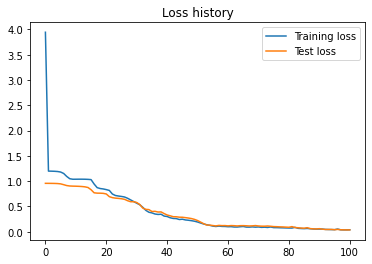

In [36]:
plt.plot(loss.history, label = 'Training loss')
plt.title('Loss history')
plt.plot(test_loss, label = 'Test loss')
plt.legend()
plt.show()

In [20]:
print('Test score: ', model.score(X_test, X_test))

Test score:  0.017611415739129145


In [0]:
scores = []
cv = KFold(n_splits=10, shuffle = True, random_state = 42)
for train_index, test_index in cv.split(X_val):
    loss = RegressionLoss()
    model_ = Model(L,loss)
    X_train_v, X_test_v = X_val.values[train_index], X_val.values[test_index]
    model_.fit(X_train_v, X_train_v, lr, epochs, batch_size, tol, print_loss = False)
    scores.append(model_.score(X_test_v, X_test_v))

In [22]:
print('Cross validation score: ', np.mean(scores))
print('Test score: ', model.score(X_test, X_test))

Cross validation score:  0.04487935954239422
Test score:  0.03243881716618395


## Extract the encoded dataset

In [0]:
X_encoded = L[1].forward_pass(L[0].forward_pass(X))

In [0]:
X_encoded.to_csv('/content/students_encoded.csv')